In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.layers import LSTM, Dense

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, PowerTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score

## R-Squared 계산 함수 정의
def show_reg_result(y_test,y_pred):
    print("Max Error: ",
      round(np.abs(y_test - y_pred).max(),3))
    print("Mean Absolute Error: ",
      round(np.abs(y_test-y_pred).mean(),3))
    print("Root Mean Squared Error: ",
      mean_squared_error(y_test,y_pred, squared=False).round(3))
    print("R-Squared: ",
      r2_score(y_test, y_pred).round(3))

## 교차 검증을 수행하는 함수 정의
def cross_validation(model, X, y, n=5):
    cv = KFold(n, shuffle=False)
    return cross_val_score(model, X, y, cv=cv).mean().round(4)

# 입력 변수 가중치
def plot_feature_weight(feature, weight, N=20):
    plt.figure(figsize=(8,int(N/2)))
    W = pd.DataFrame({'feature':feature[:N],'weight':weight[:N]})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)


#
# 1. Data Load
- Cape의 경우 BDI 정보가 없음

In [11]:
#data = pd.read_excel('PERFORMANCE_DATA(TRADE, NATION).xlsx')
data = pd.read_excel("https://raw.githubusercontent.com/coj918/github_from_HD/master/PERFORMANCE_DATA_TN.xlsx")
data.columns = ['No', 'Date', 'Line', 'Type', 'Owned', 'Vsl_Cnt', 'Route', 'Cargo',
                'POL', 'POD', 'Team', 'BDI', 'Duration', "Bunker", 'Daily_CB', 'Daily_Hire',
                'TC Index', 'PL']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14365 entries, 0 to 14364
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   No          14365 non-null  int64         
 1   Date        14365 non-null  datetime64[ns]
 2   Line        14365 non-null  object        
 3   Type        14365 non-null  object        
 4   Owned       14365 non-null  object        
 5   Vsl_Cnt     14365 non-null  int64         
 6   Route       14365 non-null  object        
 7   Cargo       14365 non-null  object        
 8   POL         14365 non-null  object        
 9   POD         14365 non-null  object        
 10  Team        14365 non-null  int64         
 11  BDI         14365 non-null  int64         
 12  Duration    14365 non-null  float64       
 13  Bunker      14365 non-null  float64       
 14  Daily_CB    14365 non-null  int64         
 15  Daily_Hire  14365 non-null  int64         
 16  TC Index    14365 non-

### 1-1) 팀 코드 숫자 -> 문자열 변환

In [12]:
data = data.astype({'Team':'str'})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14365 entries, 0 to 14364
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   No          14365 non-null  int64         
 1   Date        14365 non-null  datetime64[ns]
 2   Line        14365 non-null  object        
 3   Type        14365 non-null  object        
 4   Owned       14365 non-null  object        
 5   Vsl_Cnt     14365 non-null  int64         
 6   Route       14365 non-null  object        
 7   Cargo       14365 non-null  object        
 8   POL         14365 non-null  object        
 9   POD         14365 non-null  object        
 10  Team        14365 non-null  object        
 11  BDI         14365 non-null  int64         
 12  Duration    14365 non-null  float64       
 13  Bunker      14365 non-null  float64       
 14  Daily_CB    14365 non-null  int64         
 15  Daily_Hire  14365 non-null  int64         
 16  TC Index    14365 non-

In [13]:
data.isnull().sum()

No            0
Date          0
Line          0
Type          0
Owned         0
Vsl_Cnt       0
Route         0
Cargo         0
POL           0
POD           0
Team          0
BDI           0
Duration      0
Bunker        0
Daily_CB      0
Daily_Hire    0
TC Index      0
PL            0
dtype: int64

In [14]:
data[:3]

,No,Date,Line,Type,Owned,Vsl_Cnt,Route,Cargo,POL,POD,Team,BDI,Duration,Bunker,Daily_CB,Daily_Hire,TC Index,PL
0,1,2015-01-01,TR,Cape,OWNED,1,AD,BB00,ID,IN,63,627,5.004,414.44,736,0,0,736
1,2,2015-01-01,TR,Cape,OWNED,2,BC,BF00,BR,CN,63,627,53.791,508.82,24539,0,0,24539
2,3,2015-01-01,TR,Cape,OWNED,1,AD,BB00,AU,CN,63,627,3.917,303.09,72,0,0,72


### 1-2) datetime 분해

In [15]:
data["d-month"] = data["Date"].dt.month
data[:3]

,No,Date,Line,Type,Owned,Vsl_Cnt,Route,Cargo,POL,POD,Team,BDI,Duration,Bunker,Daily_CB,Daily_Hire,TC Index,PL,d-month
0,1,2015-01-01,TR,Cape,OWNED,1,AD,BB00,ID,IN,63,627,5.004,414.44,736,0,0,736,1
1,2,2015-01-01,TR,Cape,OWNED,2,BC,BF00,BR,CN,63,627,53.791,508.82,24539,0,0,24539,1
2,3,2015-01-01,TR,Cape,OWNED,1,AD,BB00,AU,CN,63,627,3.917,303.09,72,0,0,72,1


#
# 2. 불필요 컬럼 삭제
- 대상 : No, Duration, Bunker, TC Index, PL

In [16]:
data = data.drop(columns=['No', 'Duration', 'TC Index', 'PL'], axis=1)
data[:3]

,Date,Line,Type,Owned,Vsl_Cnt,Route,Cargo,POL,POD,Team,BDI,Bunker,Daily_CB,Daily_Hire,d-month
0,2015-01-01,TR,Cape,OWNED,1,AD,BB00,ID,IN,63,627,414.44,736,0,1
1,2015-01-01,TR,Cape,OWNED,2,BC,BF00,BR,CN,63,627,508.82,24539,0,1
2,2015-01-01,TR,Cape,OWNED,1,AD,BB00,AU,CN,63,627,303.09,72,0,1


In [17]:
data.Date.min(), data.Date.max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2023-08-01 00:00:00'))

#
# 3. 사선 항목 분리
- 사선의 경우 Daily_Hire 항목 불필요

In [18]:
df_owned = data[data.Owned == 'OWNED'].drop(columns=['Owned', 'Daily_Hire'], axis=1)
df_owned.set_index('Date', inplace=True)
df_owned[:3]

,Line,Type,Vsl_Cnt,Route,Cargo,POL,POD,Team,BDI,Bunker,Daily_CB,d-month
Date,,,,,,,,,,,,
2015-01-01,TR,Cape,1,AD,BB00,ID,IN,63,627,414.44,736,1
2015-01-01,TR,Cape,2,BC,BF00,BR,CN,63,627,508.82,24539,1
2015-01-01,TR,Cape,1,AD,BB00,AU,CN,63,627,303.09,72,1


In [19]:
print(df_owned.shape)
df_owned.info()

(4526, 12)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4526 entries, 2015-01-01 to 2023-08-01
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Line      4526 non-null   object 
 1   Type      4526 non-null   object 
 2   Vsl_Cnt   4526 non-null   int64  
 3   Route     4526 non-null   object 
 4   Cargo     4526 non-null   object 
 5   POL       4526 non-null   object 
 6   POD       4526 non-null   object 
 7   Team      4526 non-null   object 
 8   BDI       4526 non-null   int64  
 9   Bunker    4526 non-null   float64
 10  Daily_CB  4526 non-null   int64  
 11  d-month   4526 non-null   int64  
dtypes: float64(1), int64(4), object(7)
memory usage: 459.7+ KB


In [20]:
print(df_owned.shape)
df_owned = pd.get_dummies(df_owned, columns=['Line', 'Type', 'Route', 'Cargo', 'POL', 'POD', 'Team'])
print(df_owned.shape)
df_owned[:5].T

(4526, 12)
(4526, 195)


Date,2015-01-01,2015-01-01,2015-01-01,2015-01-01,2015-01-01
Vsl_Cnt,1.00,2.00,1.00,2.00,1.00
BDI,627.00,627.00,627.00,627.00,627.00
Bunker,414.44,508.82,303.09,416.69,541.68
Daily_CB,736.00,24539.00,72.00,-420.00,2109.00
d-month,1.00,1.00,1.00,1.00,1.00
...,...,...,...,...,...
Team_283,0.00,0.00,0.00,0.00,0.00
Team_37,0.00,0.00,0.00,0.00,0.00
Team_39,0.00,0.00,0.00,0.00,0.00
Team_63,1.00,1.00,1.00,1.00,0.00


#
# 6. 모델 테스트

### * 훈련 데이터/테스트 데이터를 통한 시각화 Function

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def eval_on_features(features, target, n_train, model):

    X = df_owned.index.astype("int64").values.reshape(-1, 1)
    xticks = pd.date_range(start=df_owned.index.min(), end=df_owned.index.max(), freq='M')
    #print(xticks)

    # 년도와 월을 추출하여 xticks_name을 생성합니다.
    xticks_name = [date.strftime("%Y-%m") for date in xticks]
    #month = ["Jan", "Feb", "Mar","Apr", "May", "Jun", "Jul", "Aug", 'Oct', 'Sep', 'Nov', 'Dec']
    #xticks_name = [month[int(m)]+d for m, d in zip(xticks.strftime("%m"),xticks.strftime(" %m-%d"))]
    #plt.xticks(xticks, xticks_name, rotation=90, ha='left')
    #print(xticks_name)

    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    #X_train, X_test, y_train, y_test = train_test_split(features, target)

    model.fit(X_train, y_train)
    print('Train : {:.2f}'.format(model.score(X_train, y_train)))
    print('Test : {:.2f}'.format(model.score(X_test, y_test)))

    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    plt.figure(figsize=(12, 5))

    #plt.xticks(range(0, len(xticks_name), 8), xticks_name, rotation=90, ha="left")

    plt.plot(range(n_train), y_train, label="Train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="Test")
    plt.plot(range(n_train), y_pred_train, '--', label="Train Pred")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="Test Pred")

    plt.legend(loc='best')
    plt.title(model)
    plt.xlabel("Date")
    plt.ylabel("Daily C/B")

    return y_train, y_test, y_pred

In [ ]:
X_owned = df_owned.drop('Daily_CB', axis=1)
y_owned = df_owned.Daily_CB

X_train, X_test = X_owned[:3474], X_owned[3474:]
y_train, y_test = y_owned[:3474], y_owned[3474:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train[:3], type(X_train)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3474 entries, 2015-01-01 to 2022-01-01
Columns: 194 entries, Vsl_Cnt to Team_64
dtypes: float64(1), int64(3), uint8(190)
memory usage: 780.3 KB


### 6-1) RandomForest
- 훈련 세트 : 2015/01 ~ 2021/12, 테스트 세트 : 2022/01 ~ 2023/07

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print('Train : ', rf.score(X_train, y_train)), print('Test : ', rf.score(X_test, y_test))

Train :  0.9867609556822422
Test :  0.03097349216623224


(None, None)

In [ ]:
show_reg_result(y_test, y_pred)

Max Error:  46552.8
Mean Absolute Error:  6631.831
Root Mean Squared Error:  9320.996
R-Squared:  0.031


### 6-2) LSTM

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

In [ ]:
# 입력 데이터를 3차원으로 변환
def create_sequences(data, look_back=12):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data.iloc[i:i+look_back, :-1].values)
        y.append(data.iloc[i+look_back, -1])
    return np.array(X), np.array(y)

look_back = 12
X, y = create_sequences(df_owned, look_back)

scaler = MinMaxScaler()
X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])  # 3차원 배열을 2차원으로 변환
X = scaler.fit_transform(X)
y = scaler.fit_transform(y.reshape(-1, 1))

# 다시 LSTM 입력 형태로 변환
X = X.reshape(X.shape[0], look_back, X.shape[1] // look_back)

Epoch 1/200
109/109 [==============================] - 4s 13ms/step - loss: 0.0954
Epoch 2/200
109/109 [==============================] - 1s 12ms/step - loss: 0.0644
Epoch 3/200
109/109 [==============================] - 1s 13ms/step - loss: 0.0577
Epoch 4/200
109/109 [==============================] - 1s 12ms/step - loss: 0.0526
Epoch 5/200
109/109 [==============================] - 1s 12ms/step - loss: 0.0478
Epoch 6/200
109/109 [==============================] - 1s 13ms/step - loss: 0.0469
Epoch 7/200
109/109 [==============================] - 1s 12ms/step - loss: 0.0435
Epoch 8/200
109/109 [==============================] - 1s 12ms/step - loss: 0.0415
Epoch 9/200
109/109 [==============================] - 1s 12ms/step - loss: 0.0391
Epoch 10/200
109/109 [==============================] - 1s 12ms/step - loss: 0.0375
Epoch 11/200
109/109 [==============================] - 1s 12ms/step - loss: 0.0358
Epoch 12/200
109/109 [==============================] - 1s 12ms/step - loss: 0.0331
E

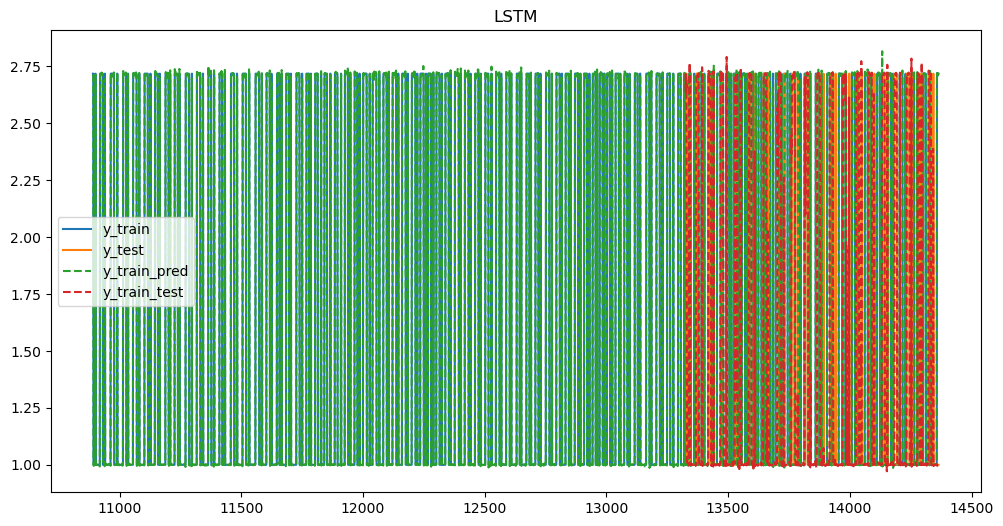

In [ ]:
#train_size = int(len(X) * 0.8)
train_size = 3474
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

model = Sequential()
model.add(LSTM(100, input_shape=(look_back, X_train.shape[2]), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=200, batch_size=32, verbose=1)

train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Train Loss: {train_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

y_train_pred = np.exp(scaler.inverse_transform(y_train_pred))
y_test_pred  = np.exp(scaler.inverse_transform(y_test_pred))
y_train_true = np.exp(scaler.inverse_transform(y_train))
y_test_true  = np.exp(scaler.inverse_transform(y_test))

plt.figure(figsize=(12, 6))
plt.title('LSTM')
plt.plot(data.index[-len(y_train_pred):], y_train_true, label='y_train')
plt.plot(data.index[-len(y_test_pred):], y_test_true, label='y_test')
plt.plot(data.index[-len(y_train_pred):], y_train_pred, label='y_train_pred', linestyle='--')
plt.plot(data.index[-len(y_test_pred):], y_test_pred, label='y_train_test', linestyle='--')
plt.legend()
plt.show()

In [ ]:
show_reg_result(y_test_true,y_test_pred)

Max Error:  1.773
Mean Absolute Error:  0.122
Root Mean Squared Error:  0.409
R-Squared:  0.675
